In [1]:
import psutil
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, is_classifier
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, TargetEncoder, label_binarize
from sklearn.svm import SVC
from xgboost import XGBClassifier
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve

from fwi_predict.constants import WQ_RANGES
from fwi_predict.wq import get_in_required_range
from fwi_predict.utils.sklearn import MulticlassCalibrationDisplay

In [2]:
# Function to create train-test splits for each target
def create_stratified_splits(df, target_cols, test_size=0.2, random_state=42):
    splits = {}
    for target in target_cols:
        # Drop rows with missing target values
        df_clean = df[df[target].astype(bool)]
        
        # Split features and target
        X = df_clean.drop(target_cols, axis=1)
        y = df_clean[target]

        le = LabelEncoder()
        ye = le.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(
          X, ye,
          test_size=test_size,
          random_state=random_state,
          stratify=ye
        )
            
        splits[target] = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'label_encoder': le
        }
    
    return splits

In [3]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'needs_imputation': True, # Because of best feature selection
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [5, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'needs_imputation': True,
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        }
    },
    # 'SVM': {
    #     'model': SVC(probability=True),
    #     'needs_imputation': True,
    #     'params': {
    #         'classifier__C': [0.1, 1.0, 10.0],
    #         'classifier__kernel': ['rbf', 'linear'],
    #         'classifier__gamma': ['scale', 'auto', 0.1, 1.0]
    #     }
    # },
    # 'Gradient Boosting': {
    #     'model': GradientBoostingClassifier(),
    #     'needs_imputation': True,
    #     'params': {
    #         'classifier__n_estimators': [100, 200],
    #         'classifier__learning_rate': [0.01, 0.1],
    #         'classifier__max_depth': [3, 7]
    #     }
    # }
}


def create_pipeline(model_info,
                    cat_vars: List[str],
                    random_state: int = 42,
                    workers = psutil.cpu_count(logical = False) - 1) -> Pipeline:
  """Create a scikit-learn pipeline for preprocessing and model training.
  
  Args:
    model_info: Dictionary containing model configuration
    cat_vars: Column names of categorical features.
    random_state: Random seed for reproducibility
      
  Returns:
    sklearn.pipeline.Pipeline: Configured pipeline
  """
  # Store pipeline steps
  steps = []
  
  # Create column transformer first
  cat_encoder = TargetEncoder(random_state=random_state)
  cat_transform = ColumnTransformer([("categorical", cat_encoder, cat_vars)], remainder='passthrough')
  steps.append(('cat_encoder', cat_transform))

  if model_info['needs_imputation']:
     steps.append(('impute', KNNImputer(n_neighbors=10)))
  
  steps.extend([
    ('scaler', StandardScaler()),
    # ('dim_reduction', SelectKBest(score_func=f_classif, k=50)), 
    ('classifier', model_info['model'])
  ])

  return Pipeline(steps)


def plot_feature_importance(X_train, y_train):
    # Feature importance using permutation importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(rf, X_train, y_train, 
                                             n_repeats=10, n_jobs=-1, random_state=42)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features (Permutation Importance)')
    plt.show()
    
    return feature_importance


def train_models(X_train: Union[pd.DataFrame, np.ndarray],
                 y_train: Union[pd.DataFrame, np.ndarray],
                 cat_vars: List[str],
                 folds: int = 5) -> Dict[str, BaseEstimator]:
    results = {}
    
    # Create figure for plotting
    plt.figure(figsize=(10, 6))
    
    for idx, (name, model_info) in enumerate(models.items()):
        print(f"\nTraining {name}...")
        
        # Create pipeline
        param_grid = model_info['params'].copy()
        pipeline = create_pipeline(model_info, cat_vars)
        
        # Create CV object
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        
        # Define scoring metrics for each class
        scoring = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }
        
        # Perform grid search with multiple scoring metrics
        grid_search = GridSearchCV(
          pipeline, param_grid,
          cv=cv, scoring=scoring, 
          refit='accuracy', n_jobs=-1,
          return_train_score=True
        )
        
        # Fit model
        grid_search.fit(X_train, y_train)
        
        # Get best model and score
        best_score = grid_search.best_score_
        best_pipeline = grid_search.best_estimator_
        
        print(f"Best CV accuracy score: {best_score:.3f}")
        
        # Store best model
        results[name] = best_pipeline
        
        # Plot CV scores from grid search results
        plt.subplot(1, 2, idx+1)
        
        # Extract CV results for visualization
        cv_results = pd.DataFrame(grid_search.cv_results_)
        
        # Get scores for best parameters
        # Need to fix this figure.
        best_idx = cv_results['rank_test_accuracy'] == 1
        cv_scores = {
            'Accuracy': cv_results.loc[best_idx, [f'split{i}_test_accuracy' for i in range(folds)]].values[0],
            'Precision': cv_results.loc[best_idx, [f'split{i}_test_precision_macro' for i in range(folds)]].values[0], 
            'Recall': cv_results.loc[best_idx, [f'split{i}_test_recall_macro' for i in range(folds)]].values[0],
        }
        
        # Reshape data for seaborn plotting
        scores_df = pd.DataFrame(cv_scores)
        scores_df = scores_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
        scores_df['Fold'] = scores_df['index'].map(lambda x: f'Fold {x+1}')
        
        # Create grouped bar plot using seaborn
        sns.barplot(data=scores_df, x='Metric', y='Score', hue='Fold', dodge=True)
        plt.title(f'{name} CV Performance Metrics')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    plt.tight_layout()
    plt.show()
    
    return results

# Function to compare model performances
def compare_models(models_dict: Dict[str, BaseEstimator],
                   X_test: Union[pd.DataFrame, np.ndarray],
                   y_test: Union[pd.DataFrame, np.ndarray],
                   encoder: Union[Dict, LabelEncoder] = None) -> None:
    # Create subplots for different visualizations
    fig, axes = plt.subplots(len(models_dict), 4, figsize=(25, 5*len(models_dict)))
    
    for idx, (name, model) in enumerate(models_dict.items()):
        # Confusion Matrix
        cm = ConfusionMatrix(model,
                             ax=axes[idx, 0],
                             encoder=encoder)
        cm.score(X_test, y_test)
        cm.ax.set_title(f'{name} - Confusion Matrix')

        # Classification Report
        cr = ClassificationReport(model,
                                  ax=axes[idx, 1], 
                                  classes=list(reversed(encoder.classes_))) # Hacky fix because function is broken.
        cr.score(X_test, y_test)
        cr.ax.set_title(f'{name} - Classification Report')

        # Calibration Plot
        if len(model.classes_) == 2:
          pos_label = np.where(encoder.classes_ != 'within')[0][0]
          pos_name = [c for c in encoder.classes_ if c != 'within'][0]
          cal_display = CalibrationDisplay.from_estimator(model, X_test,y_test,
                                                          n_bins=10,
                                                          ax=axes[idx, 2],
                                                          pos_label=pos_label,
                                                          name=pos_name)
          axes[idx, 2].grid(False)
        else:
          cal_display = MulticlassCalibrationDisplay.from_estimator(model, X_test, y_test,
                                                                    encoder=encoder)
          cal_display.plot(ax=axes[idx, 2])

        axes[idx, 2].set_title(f'{name} - Calibration Plot')

        # Precision-Recall Curve
        prc = PrecisionRecallCurve(model,
                                   ax=axes[idx, 3],
                                   encoder=encoder,
                                   per_class=True)
        prc.score(X_test, y_test)
        prc.ax.set_title(f'{name} - Precision-Recall Curve')

    plt.tight_layout()
    plt.show()


In [4]:
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv")

In [5]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv", parse_dates=['sample_dt'])

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'pond_id', 'region', 'farm_id', 'geometry'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
predict_df['morning'] = predict_df['hour'] < 12
predict_df['time_of_day'] = predict_df['morning'].apply(lambda x: 'morning' if x else 'evening')
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  predict_df[range_name] = get_in_required_range(param, predict_df[param], predict_df['time_of_day'])

predict_df = predict_df.drop(columns=['morning', 'time_of_day', 'sample_dt'])
classify_df = predict_df.loc[:, ~predict_df.columns.isin(WQ_RANGES.keys())]
regress_df = predict_df[predict_df.columns[~predict_df.columns.str.endswith('_in_range')].tolist()]
# predict_df.head()


Processing target: do_in_range

Training Random Forest...
Best CV accuracy score: 0.848

Training XGBoost...
Best CV accuracy score: 0.852


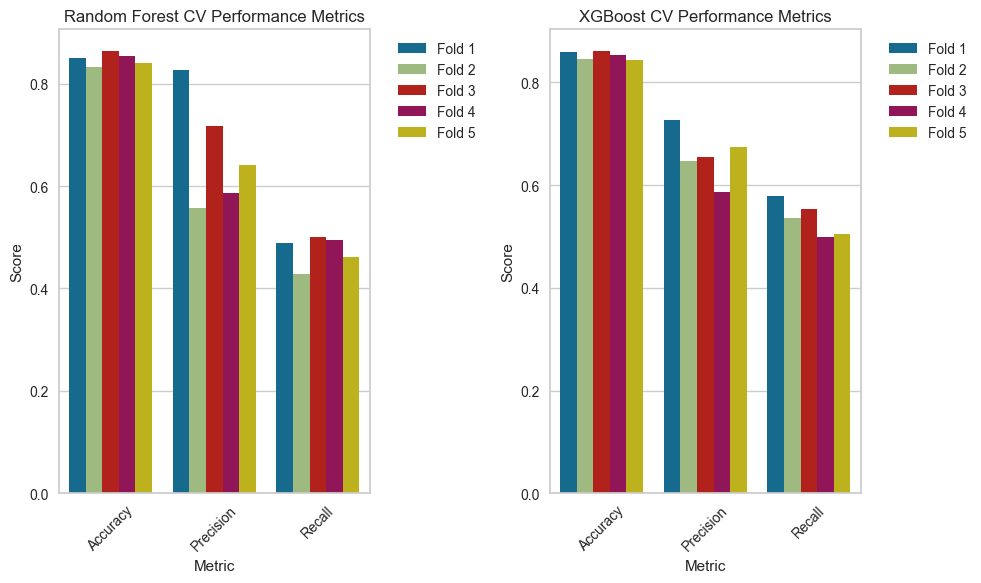

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


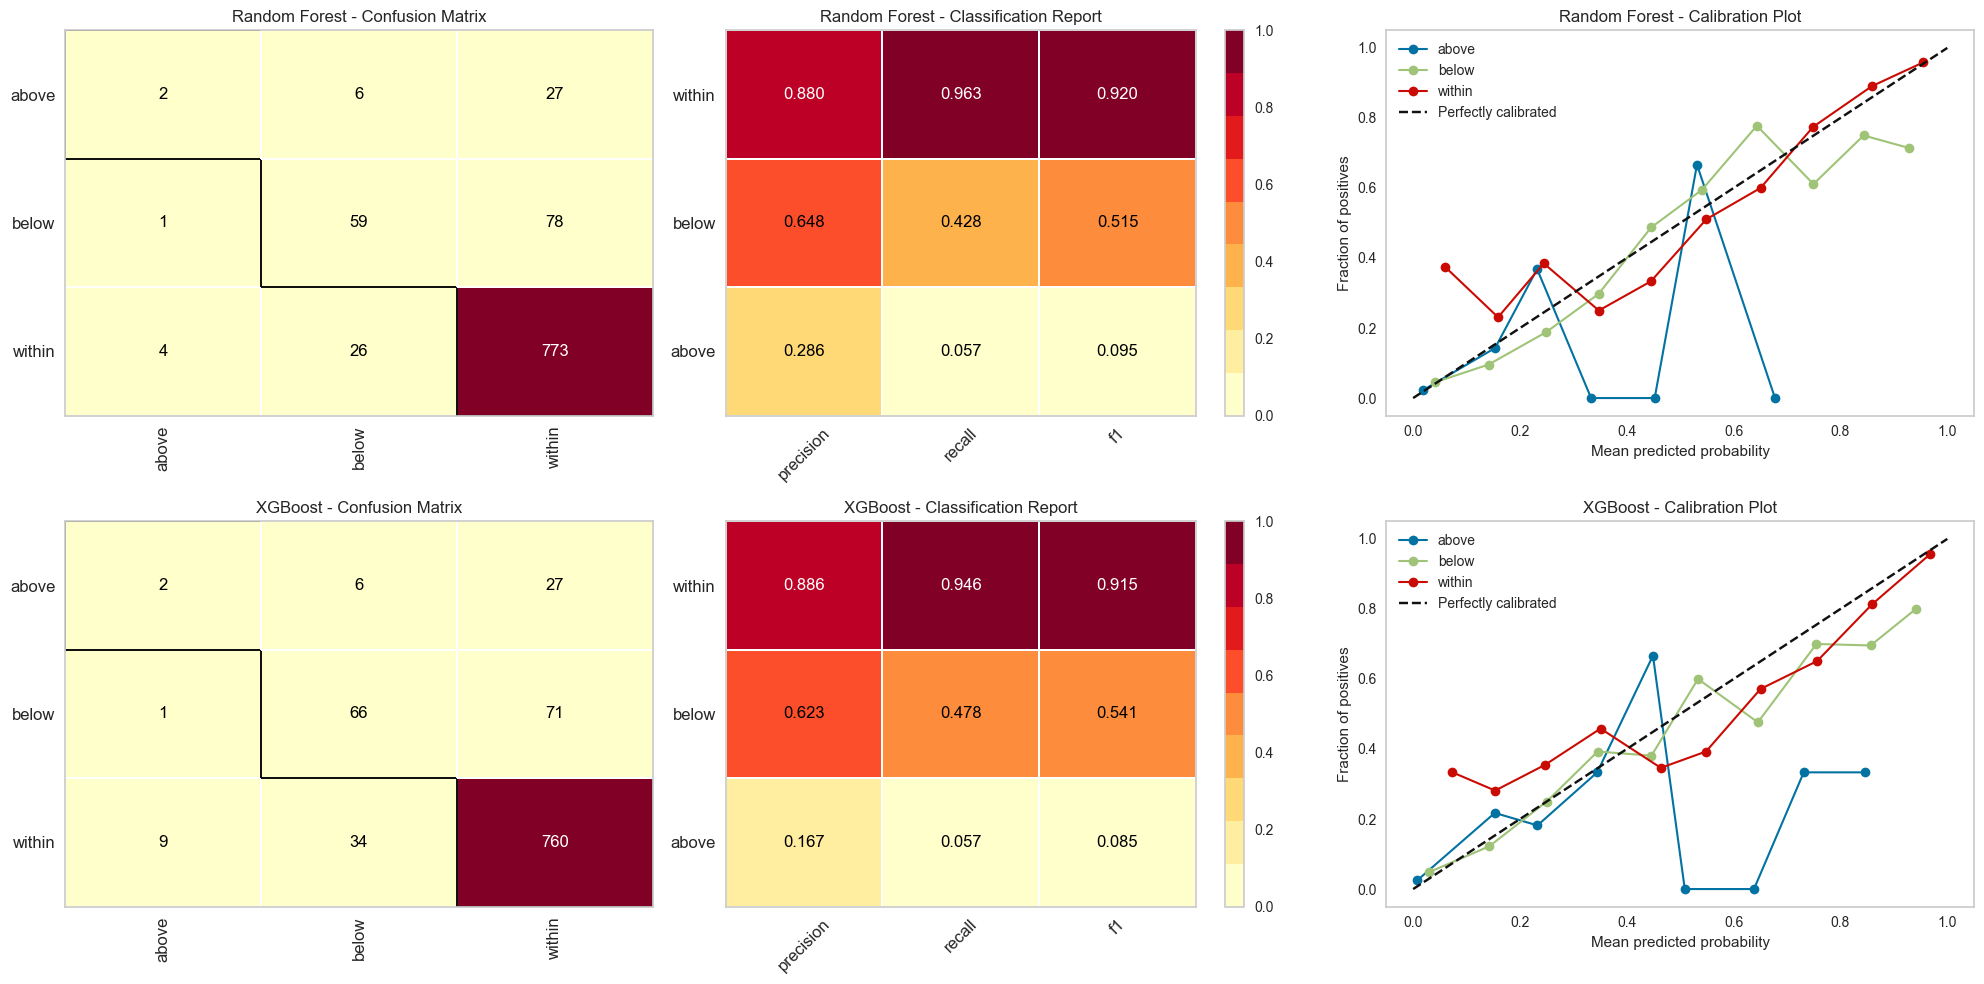


Processing target: ph_in_range

Training Random Forest...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best CV accuracy score: 0.927

Training XGBoost...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best CV accuracy score: 0.929


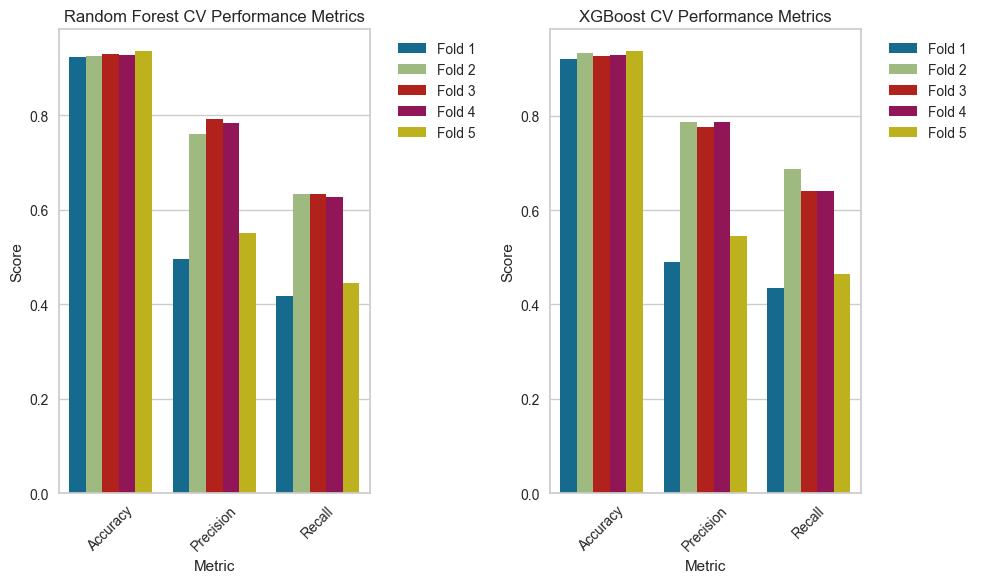

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\G

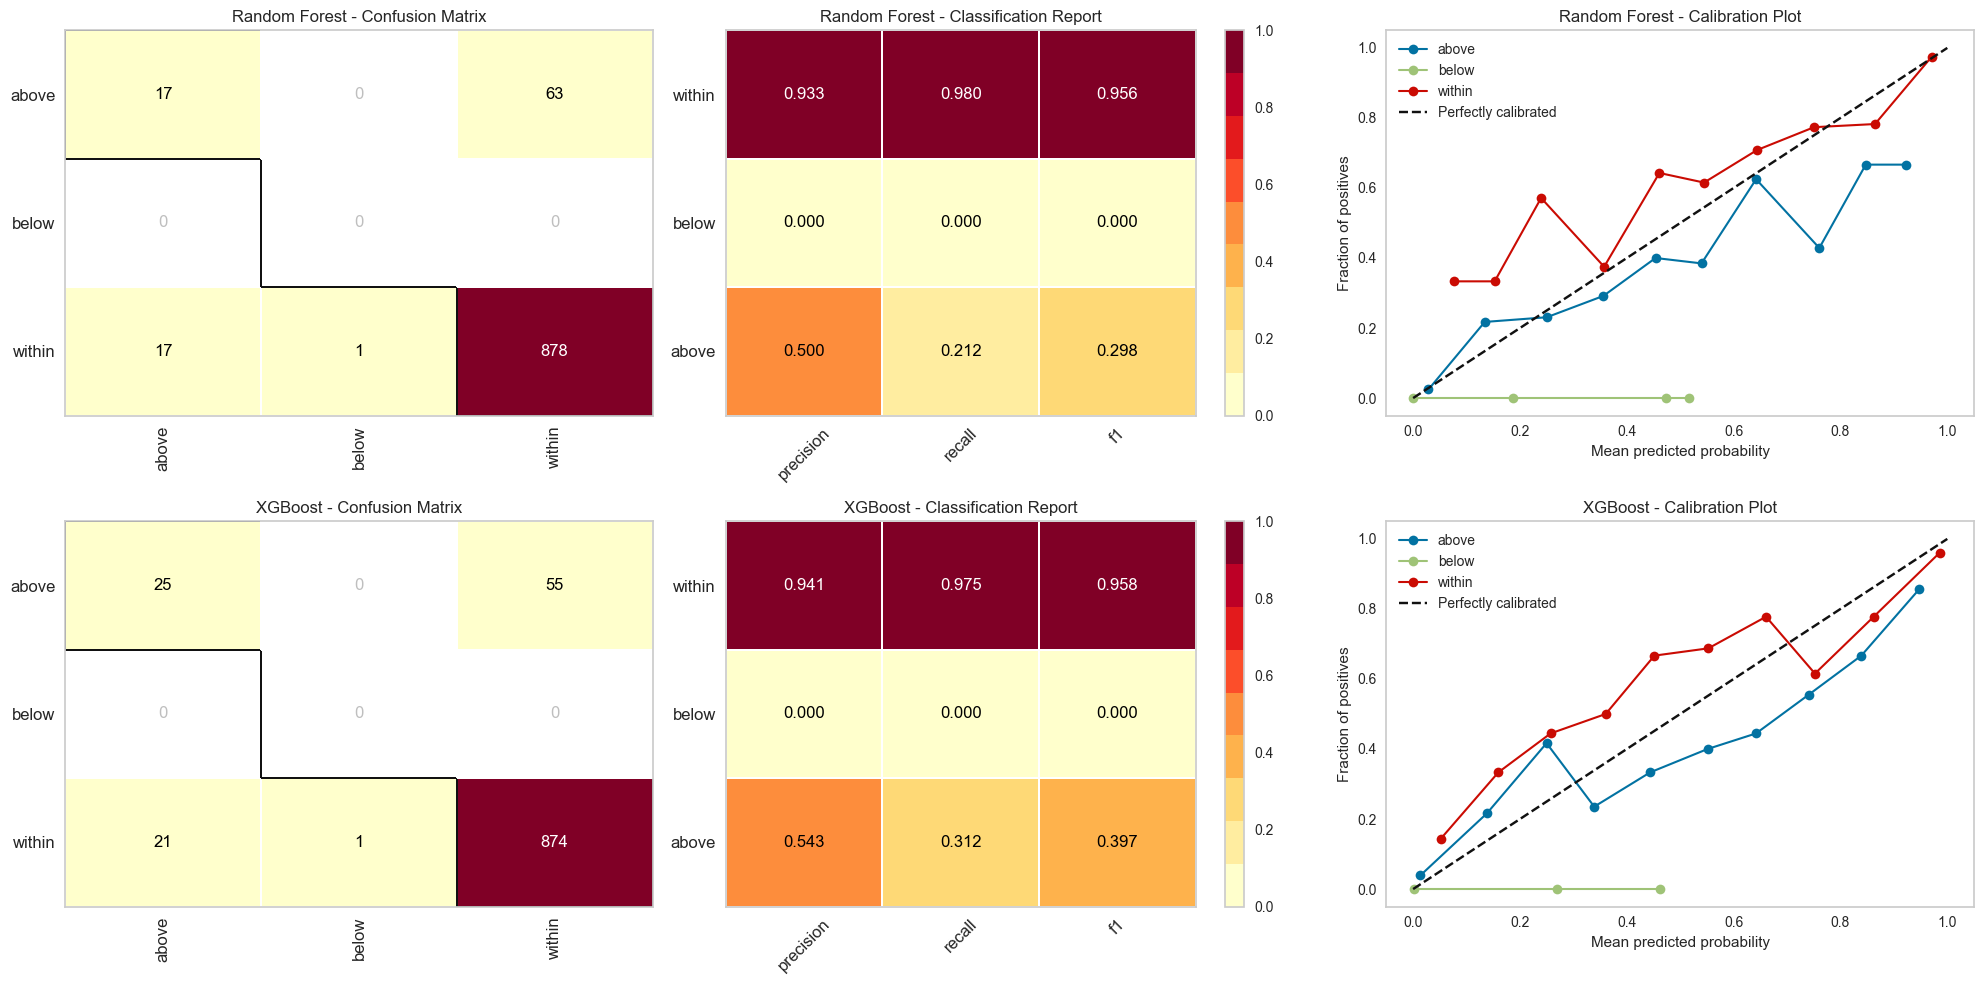


Processing target: ammonia_in_range

Training Random Forest...
Best CV accuracy score: 0.970

Training XGBoost...
Best CV accuracy score: 0.972


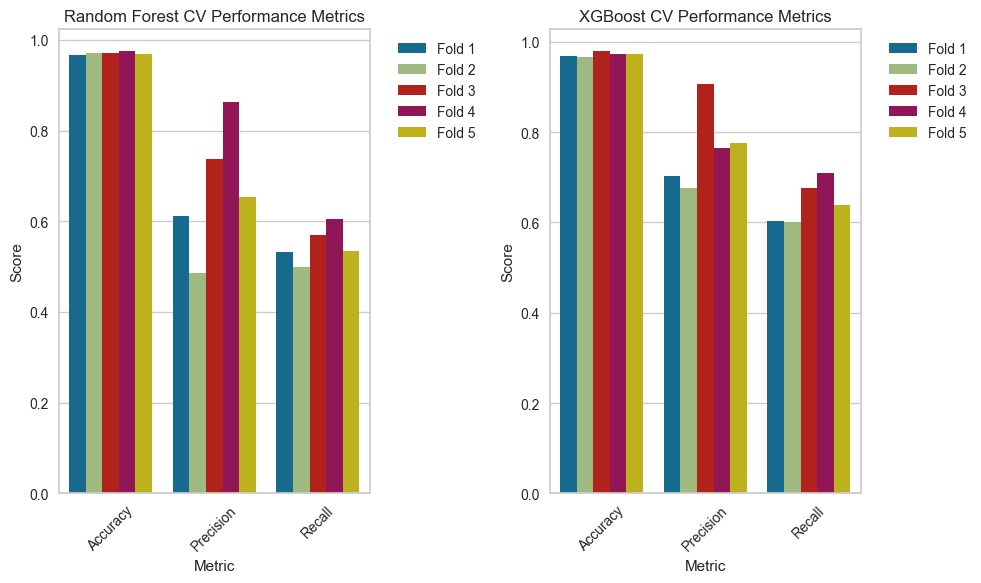

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


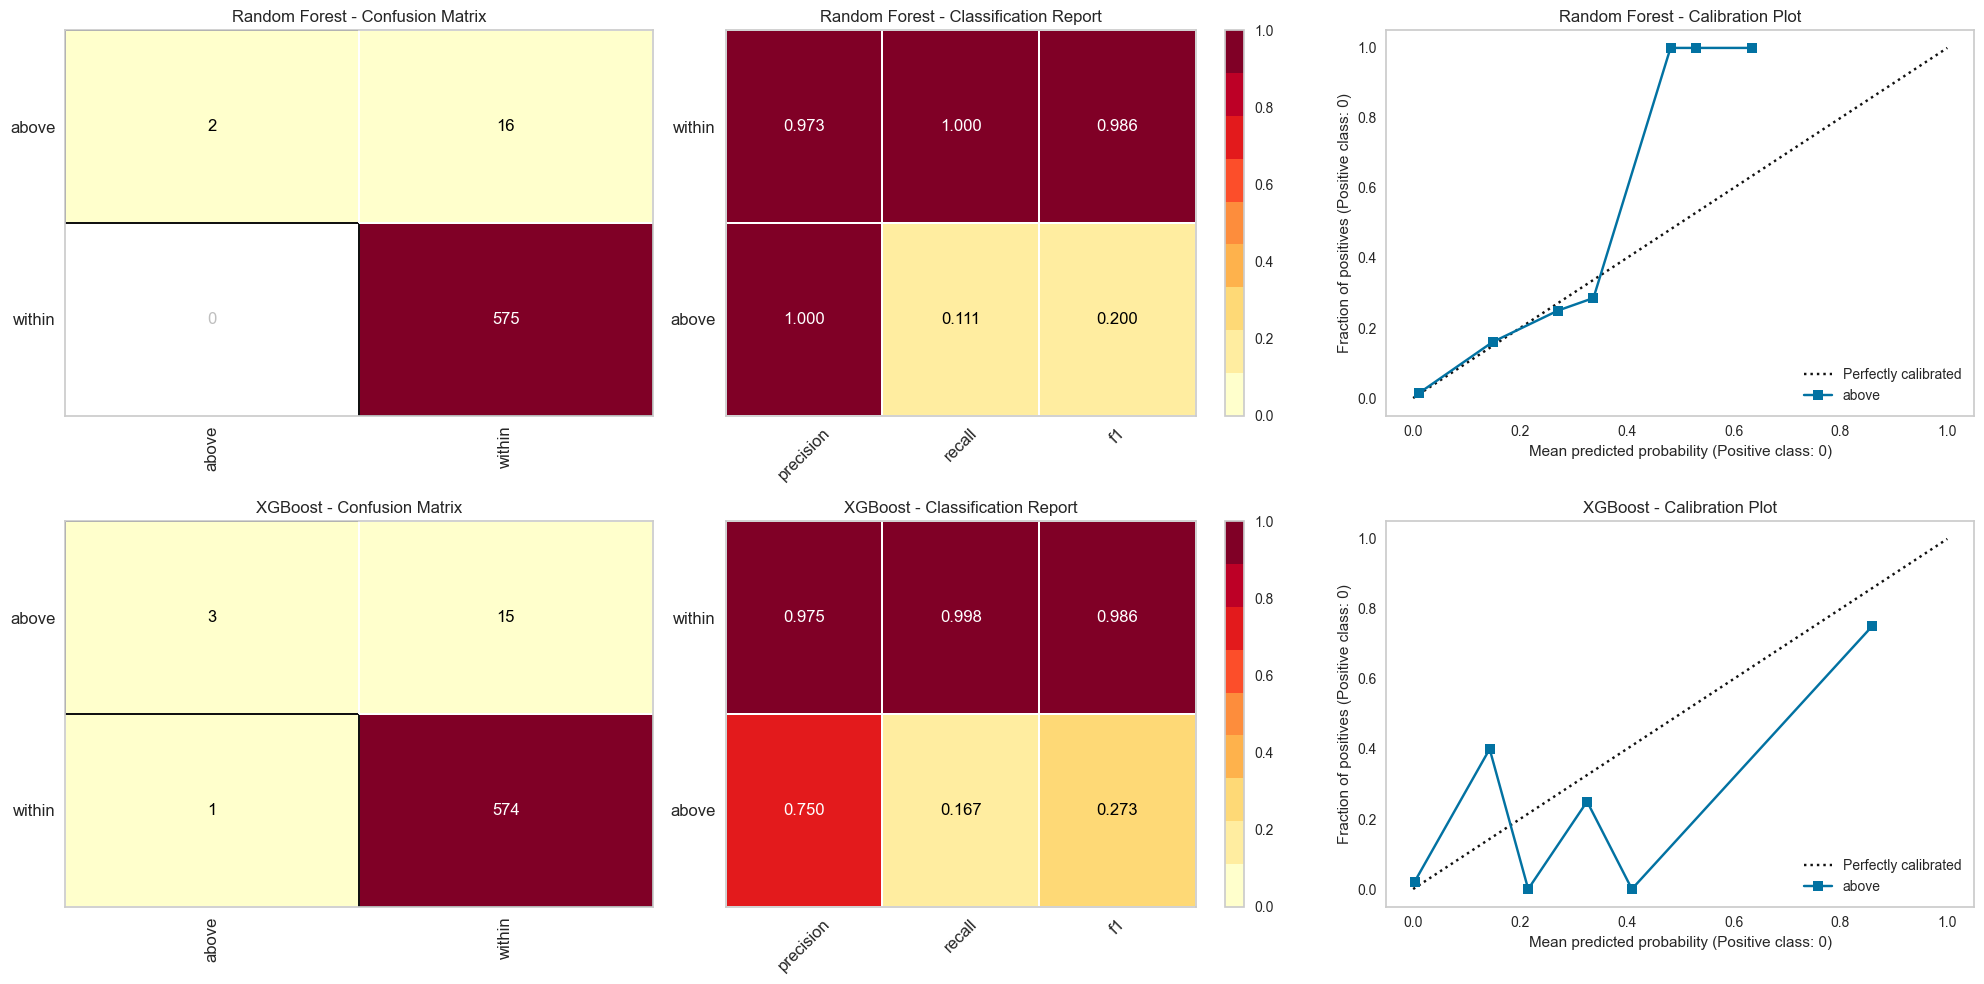


Processing target: turbidity_in_range

Training Random Forest...
Best CV accuracy score: 0.918

Training XGBoost...
Best CV accuracy score: 0.932


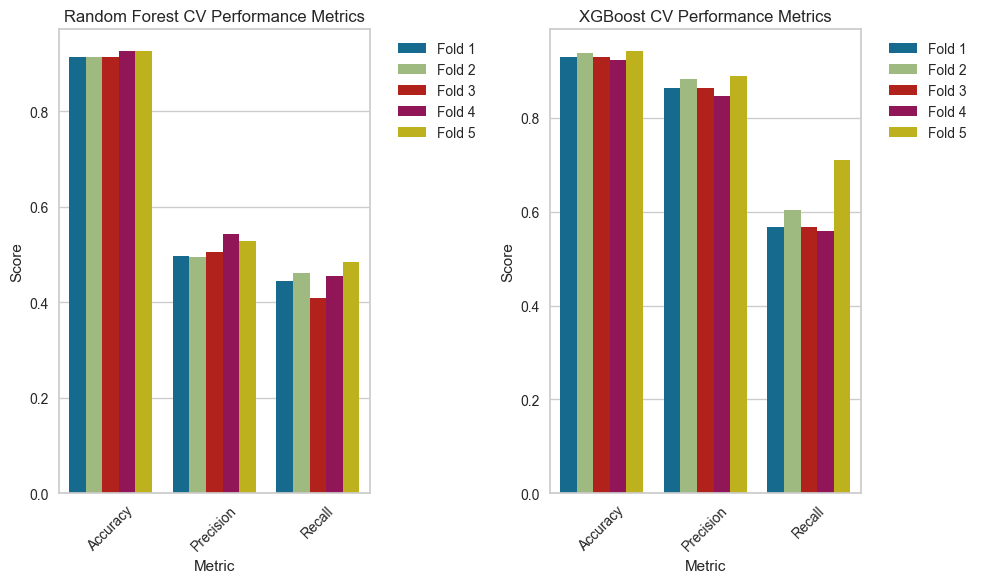

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Doc

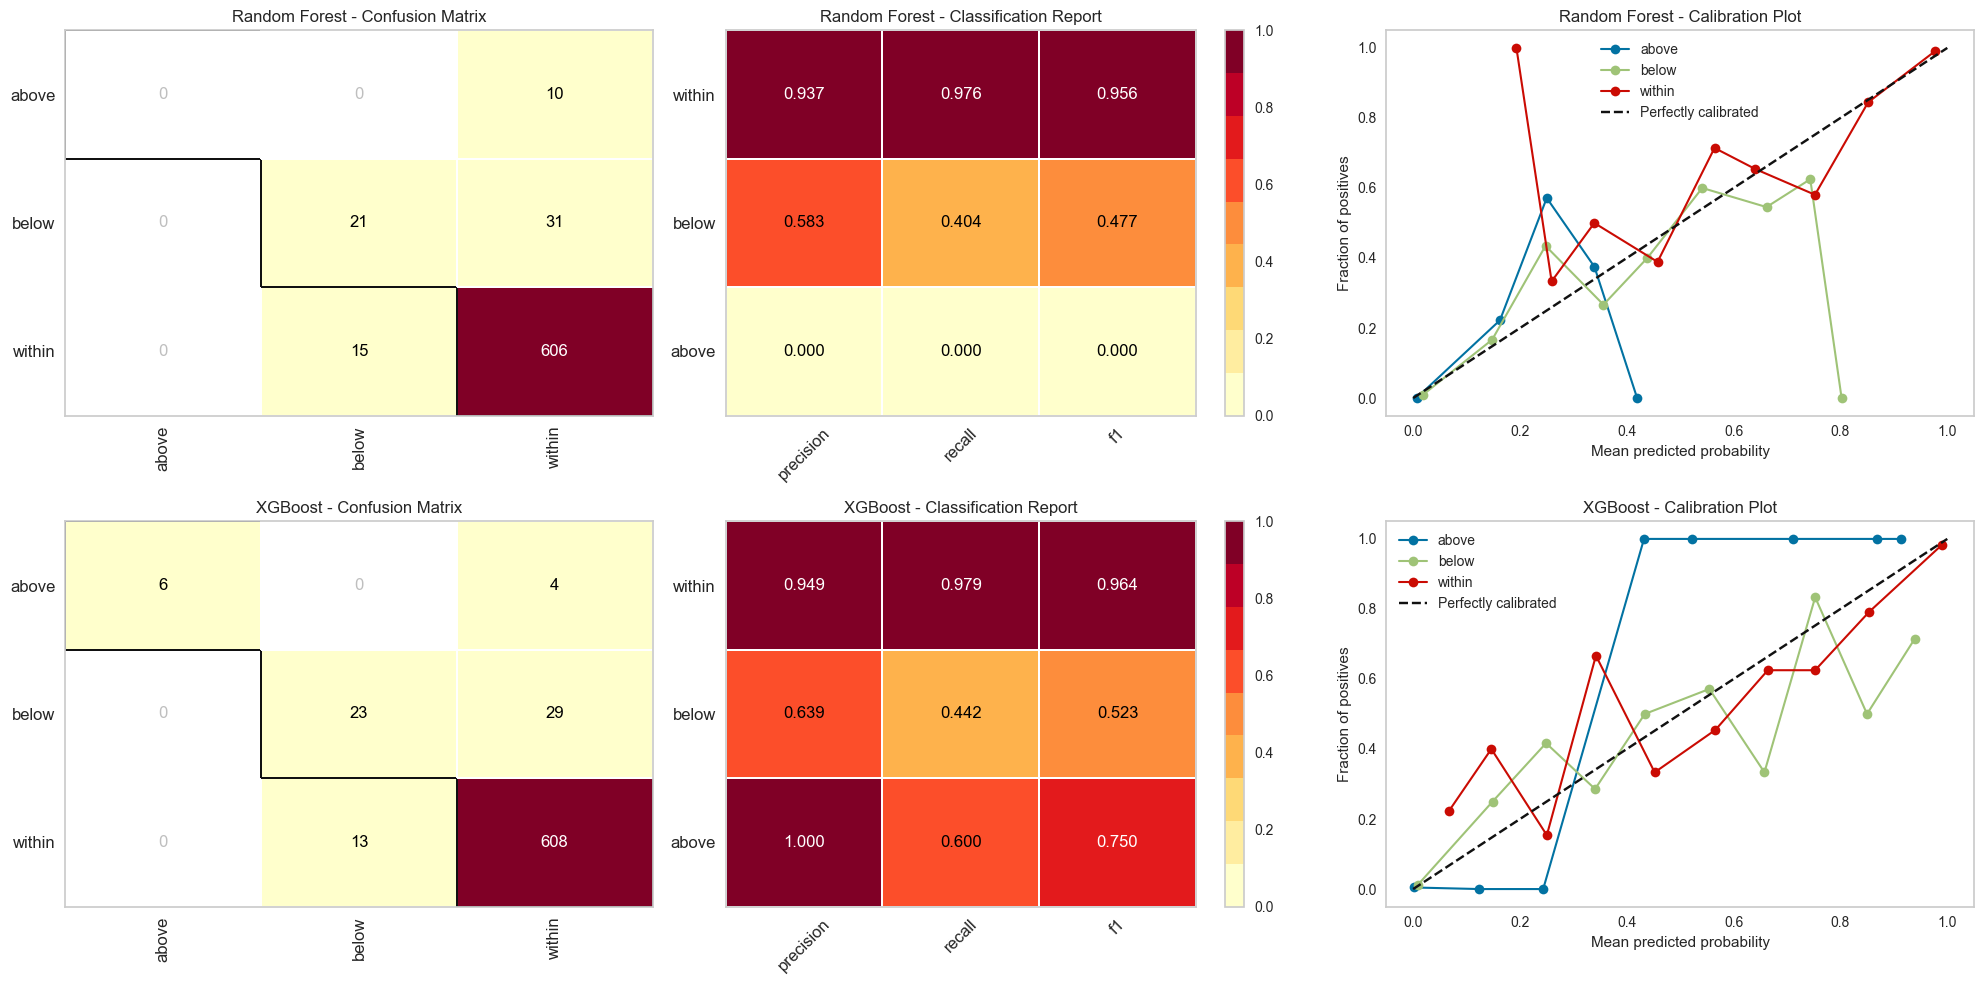

In [6]:
target_columns = ['do_in_range', 'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']  # Replace with actual target column names

# Categorical encoder params
cat_vars = ['month']
feature_dtype_dict = {
  'categorical': cat_vars,
  'non_categorical': classify_df.columns[~classify_df.columns.isin(cat_vars + target_columns)].tolist()
}

# Create splits for each target
splits = create_stratified_splits(classify_df, target_columns, random_state=42)

# For each target, train and evaluate models
final_models = {}
for target in target_columns:
    print(f"\nProcessing target: {target}")
    print("=" * 50)
    
    # Get split data for current target
    split_data = splits[target]

    # Plot feature importance
    # _ = plot_feature_importance(split_data['X_train'], split_data['y_train'])
    
    # Train and evaluate models
    trained_models = train_models(split_data['X_train'], split_data['y_train'], cat_vars)
    
    # Compare model performances
    compare_models(trained_models,
                   split_data['X_test'],
                   split_data['y_test'],
                   encoder=split_data['label_encoder'])
    
    # Store final models
    final_models[target] = {
      'models': trained_models,
      'encoder': split_data['label_encoder']
    }

In [7]:
X = classify_df.drop(columns=target_columns)
X.isna().sum(axis=0).sort_values(ascending=False)

pond_area_acres                                        775
total_cloud_cover_entire_atmosphere_21                   0
total_precipitation_surface_33                           0
total_precipitation_surface_21                           0
total_precipitation_surface_15                           0
                                                      ... 
precipitable_water_entire_atmosphere_sample              0
precipitable_water_entire_atmosphere_same_day_sum        0
precipitable_water_entire_atmosphere_before_day_sum      0
precipitable_water_entire_atmosphere_8                   0
month                                                    0
Length: 125, dtype: int64

In [8]:
import pickle
from pathlib import Path

model_dir = Path("..") / "models" / "measurements_with_metadata_simple"
model_dir.mkdir(parents=True, exist_ok=True)

for target, model_dict in final_models.items():
		target_dir = model_dir / target
		target_dir.mkdir(exist_ok=True)
		encoder = model_dict['encoder']

		for model_name, model in model_dict['models'].items():

			model_fp =  target_dir / F'{model_name}.pkl'
			encoder_fp = target_dir / "encoder.pkl"

			with open(model_fp, "wb") as f:
				pickle.dump(model, f)

			with open(encoder_fp, "wb") as f:
				pickle.dump(encoder, f)
		

In [9]:
for target, model_dict in final_models.items():
  for model_name, model in model_dict['models'].items():
    if hasattr(model, 'named_steps'):
        selector = model.named_steps['dim_reduction']
        if hasattr(selector, 'get_support'):
            selected_features = X.columns[X.columns.isin(selector.get_support())].tolist()
            print(f"\n{model_name} selected features:")
            print(selected_features)

KeyError: 'dim_reduction'

### Characterize where performance is no good

In [54]:
def plot_feature_error_distributions(model, encoder, X_test, y_test, max_features=10, figsize=(15, 25)):
    """Create an elegant visualization showing feature distributions and model prediction accuracy.
    
    Generates a multi-panel plot showing violin plots of the most important features, colored by whether
    the model's predictions were correct or incorrect. Each subplot includes feature importance scores
    and is styled with a modern, clean aesthetic.
    
    Args:
        model: Fitted sklearn model with feature_importances_ attribute
        encoder: LabelEncoder used to encode target variable 
        X_test: Test feature matrix
        y_test: True test labels
        max_features: Maximum number of top features to display (default: 10)
        figsize: Figure dimensions as (width, height) tuple (default: (15, 25))
    """
    # Extract feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps'):
        final_estimator = model.named_steps['classifier']
        importances = final_estimator.feature_importances_
    else:
        raise AttributeError("Model does not have feature_importances_ attribute")
        
    feature_names = X_test.columns
    
    # Get top features by importance
    indices = np.argsort(importances)[::-1]
    top_features = feature_names[indices[:max_features]]
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Prepare plot data
    plot_data = []
    for feature in top_features:
        temp_df = pd.DataFrame({
            'Feature': feature,
            'Value': X_test[feature],
            'Predicted': encoder.inverse_transform(y_pred),
            'Correct': y_pred == y_test,
            'Importance': importances[indices[np.where(feature_names == feature)[0][0]]]
        })
        plot_data.append(temp_df)
    plot_df = pd.concat(plot_data)
    
    # Set modern aesthetic style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    # Create FacetGrid with refined styling
    g = sns.FacetGrid(
        plot_df,
        col='Feature',
        col_wrap=3,
        height=4,
        aspect=1.5,
        sharex=False,
        sharey=False
    )
    
    # Add violin plots with custom styling
    g.map_dataframe(
        sns.violinplot,
        x='Predicted',
        y='Value',
        hue='Correct',
        palette=['#FF6B6B', '#4ECDC4'],  # Modern color scheme
        inner='quartile',
        cut=0,
        saturation=0.8
    )
    
    # Enhance subplot aesthetics
    for ax, feature in zip(g.axes, top_features):
        importance = plot_df[plot_df['Feature'] == feature]['Importance'].iloc[0]
        ax.set_title(f'{feature}\nImportance: {importance:.3f}', pad=10, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('')
        
        # Add subtle grid
        ax.grid(True, alpha=0.3)
        
        # Adjust spines
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
            
    # Add refined legend
    g.add_legend(
        title='Prediction Accuracy',
        labels=['Incorrect', 'Correct'],
        frameon=True,
        framealpha=0.9,
        edgecolor='white'
    )
    
    # Add title with styling
    g.fig.suptitle(
        'Feature Distribution Analysis by Prediction Outcome',
        y=1.02,
        fontsize=14,
        fontweight='bold'
    )
    
    # Adjust layout for clean presentation
    plt.tight_layout()
    
    return g.fig



Analyzing do_in_range


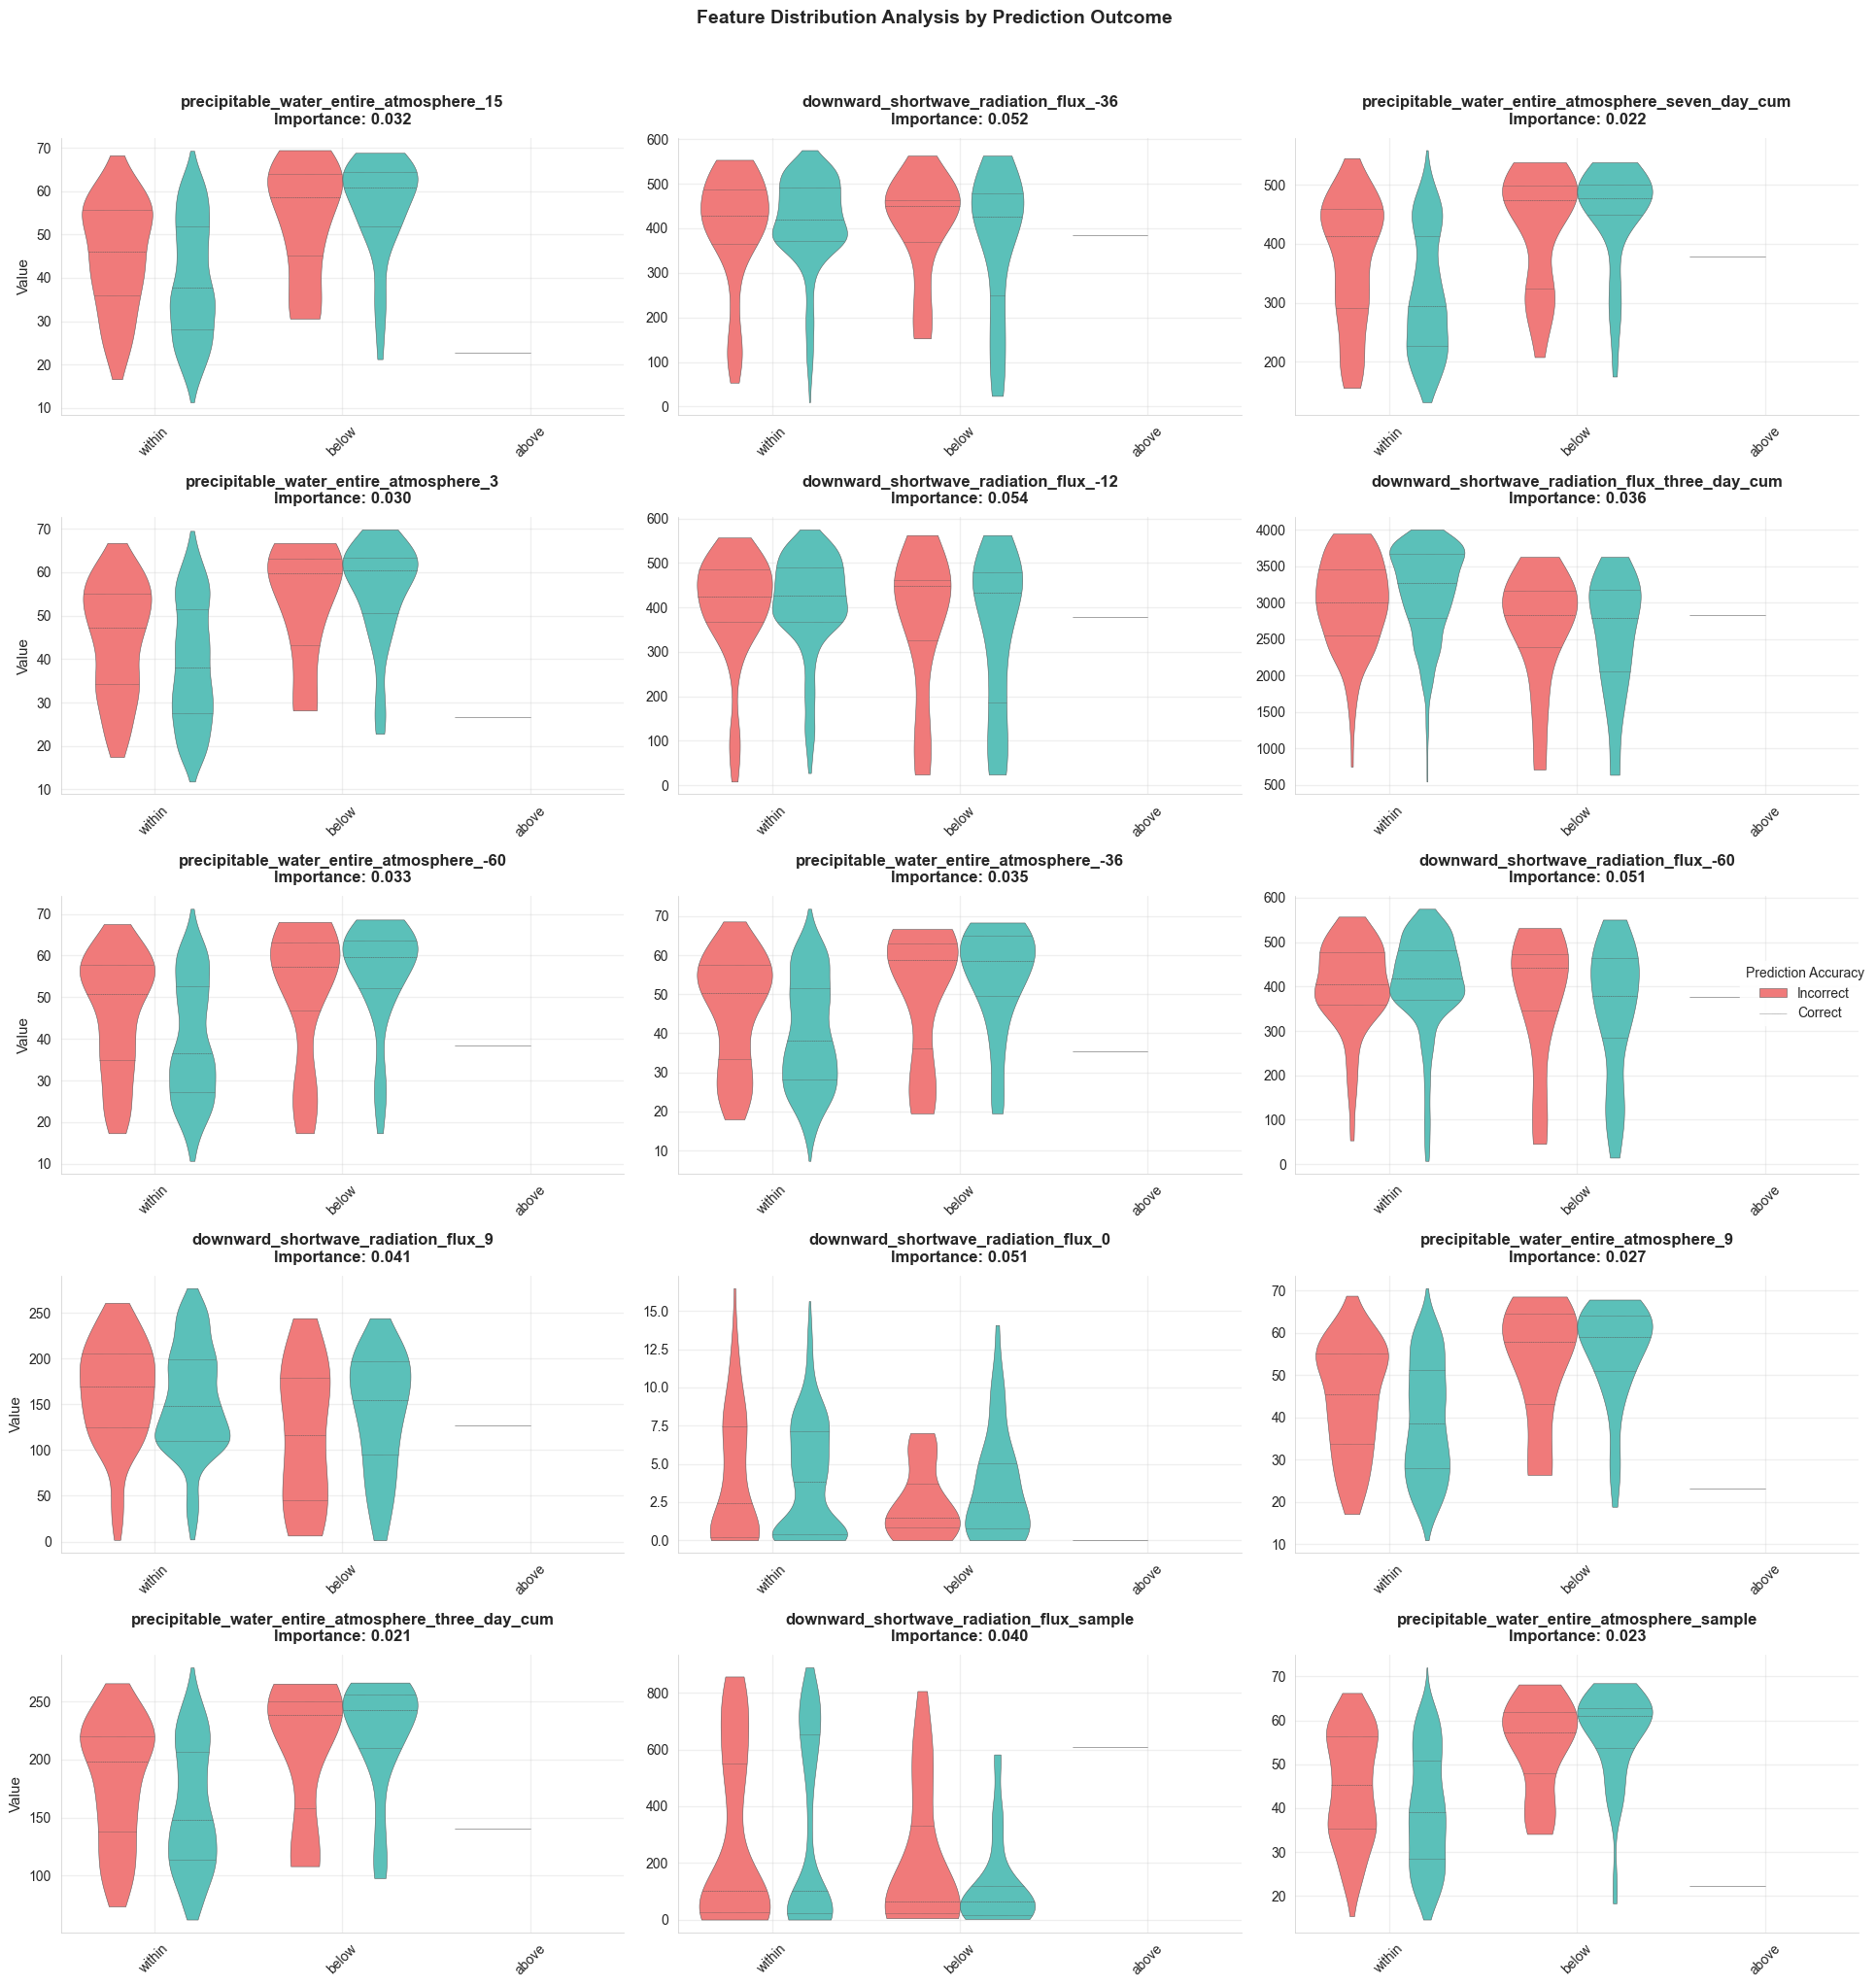

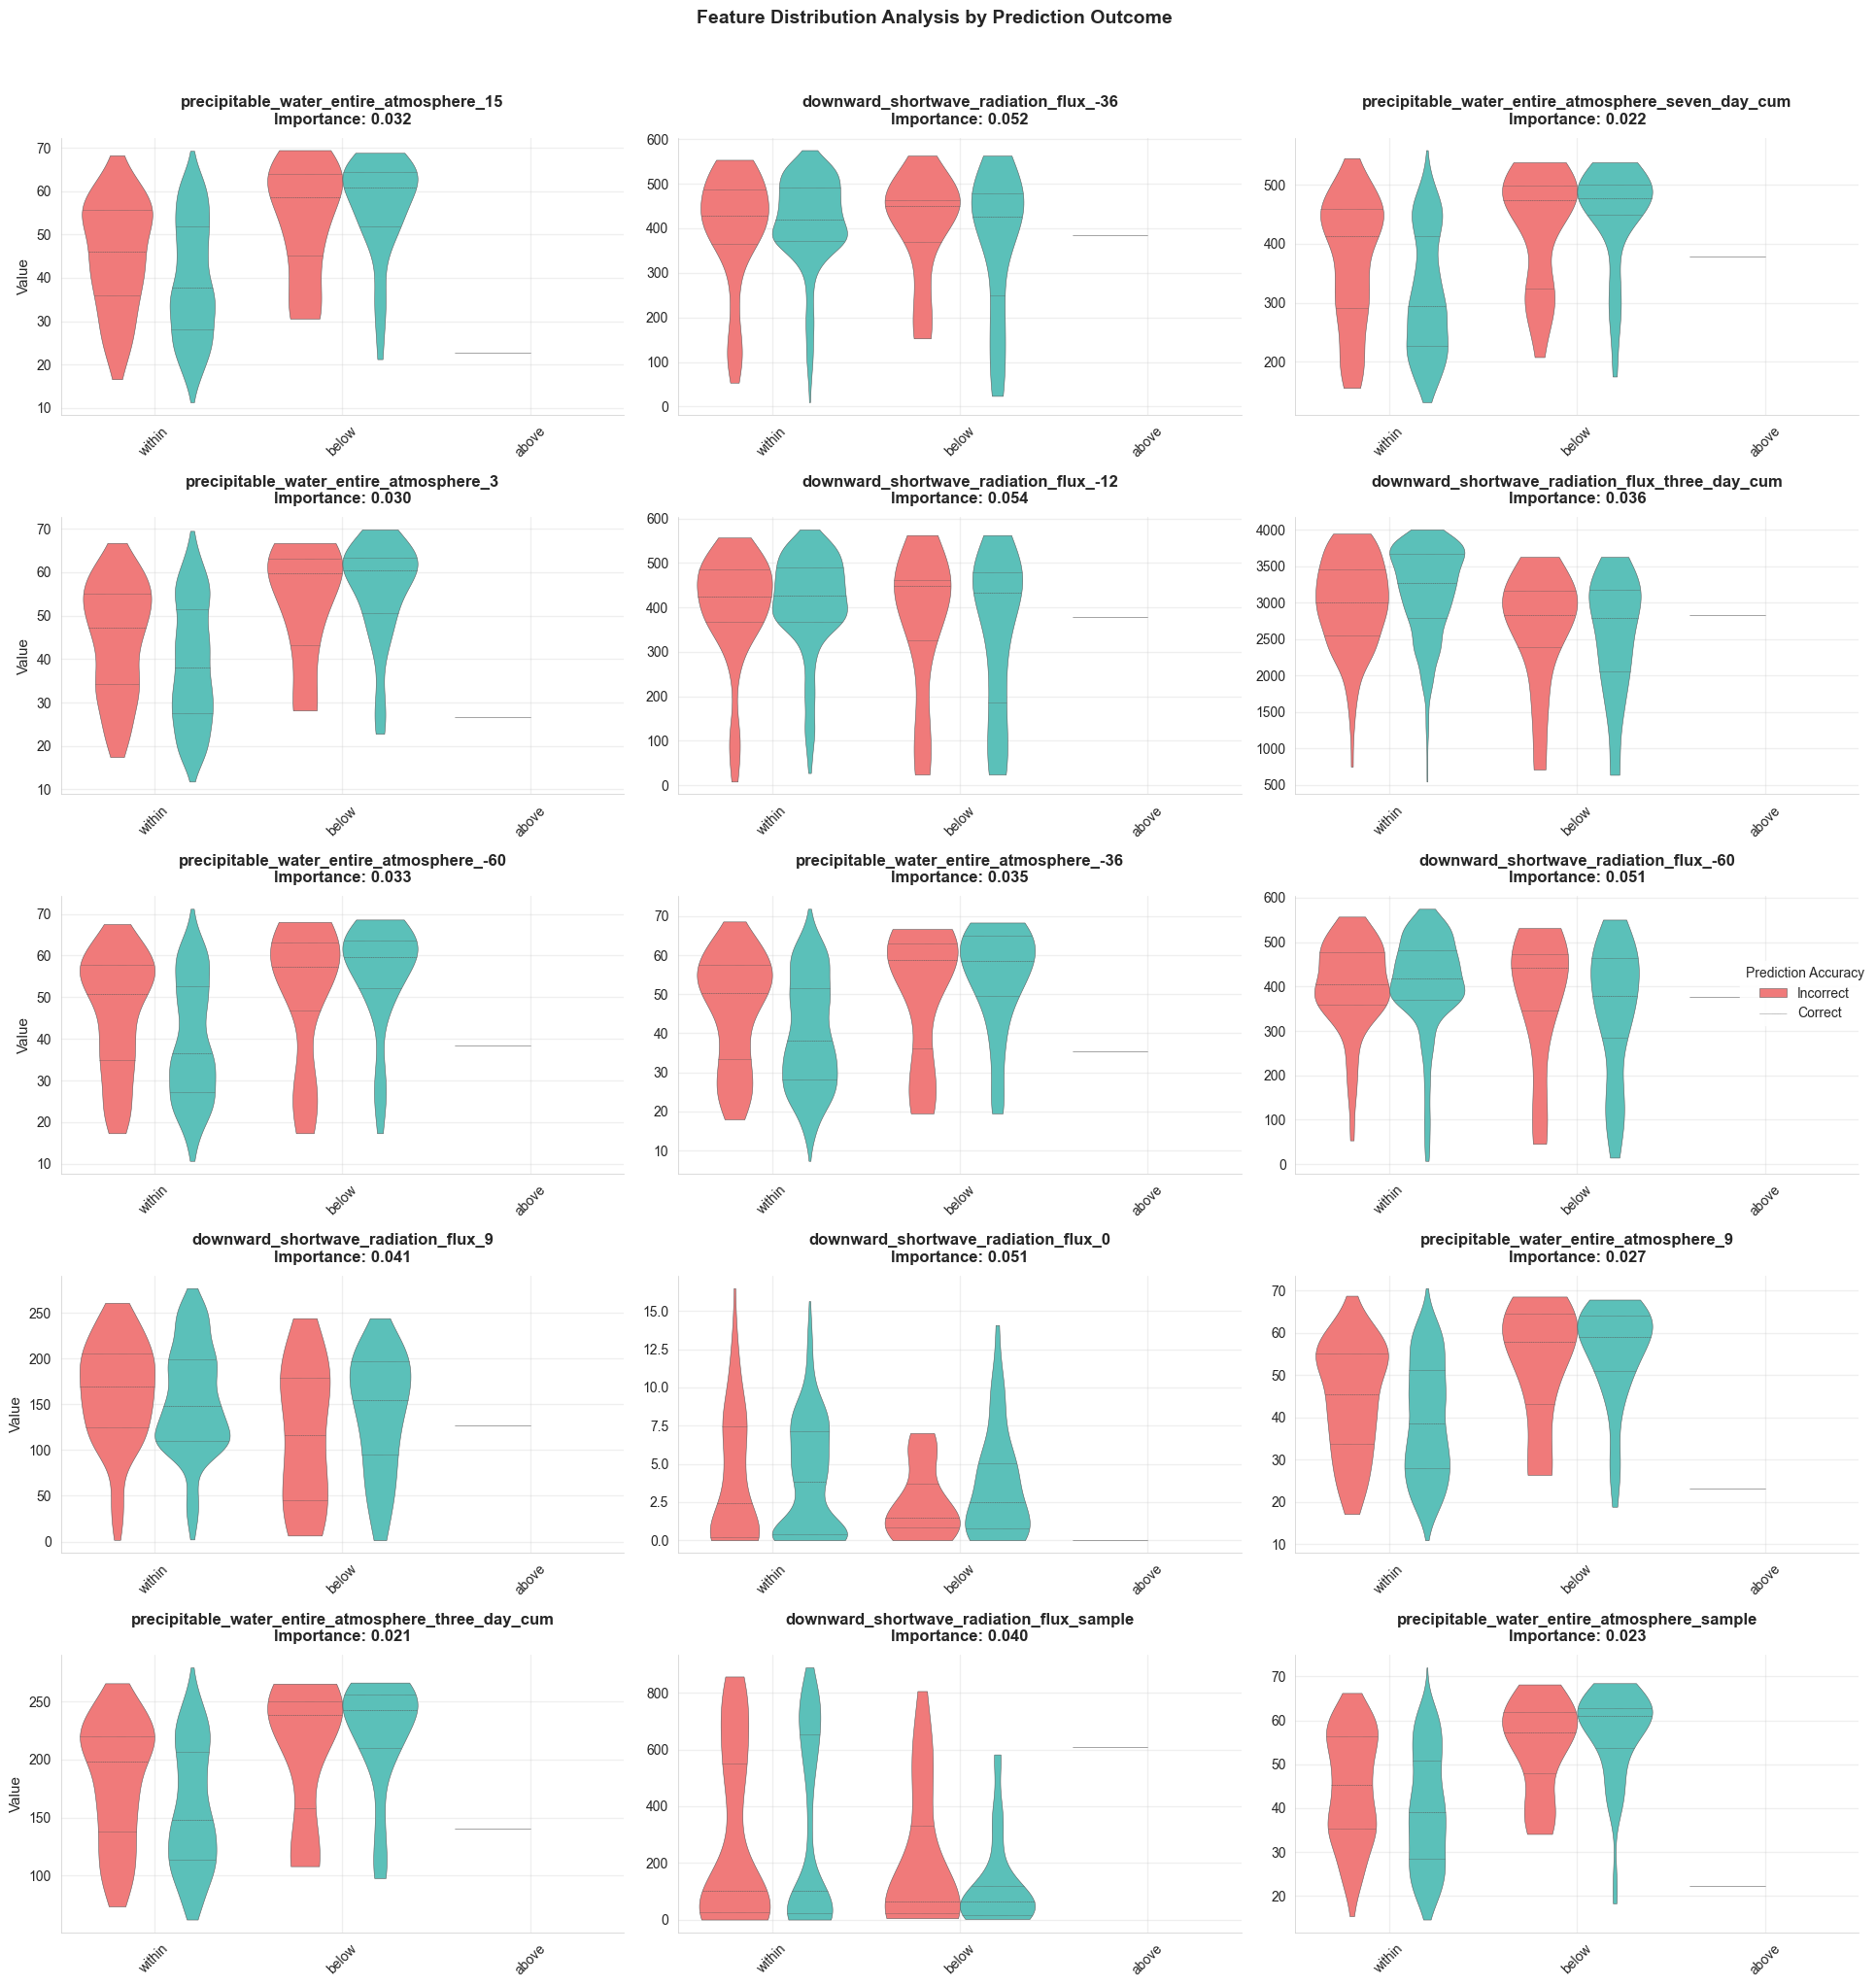

In [55]:
# Analyze just the DO random forest model
target = 'do_in_range'
model_info = final_models[target]
model = model_info['models']['Random Forest']
split_data = splits[target]

print(f"\nAnalyzing {target}")
print("=" * 50)

plot_feature_error_distributions(
    model,
    split_data['label_encoder'],  # Using split_data's encoder to ensure correct labels
    split_data['X_test'],
    split_data['y_test'],
    max_features=15,
    figsize=(15, 20)
)

In [56]:
def analyze_prediction_errors(model, encoder, X_test, y_test):
    """Analyze where the model makes mistakes.
    
    Args:
        model: Fitted sklearn model
        encoder: LabelEncoder used to encode target variable
        X_test: Test feature matrix
        y_test: True test labels
    """
    # Get predictions and actual values
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Create error analysis DataFrame
    error_df = pd.DataFrame({
        'true_label': encoder.inverse_transform(y_test),
        'predicted_label': encoder.inverse_transform(y_pred),
        'correct': y_pred == y_test,
        'confidence': np.max(y_pred_proba, axis=1)
    })
    
    # Add feature values
    error_df = pd.concat([error_df, X_test.reset_index(drop=True)], axis=1)
    
    # Analyze errors by class
    print("Error Analysis by Class:")
    print(pd.crosstab(error_df['true_label'], 
                      error_df['predicted_label'], 
                      normalize='index'))
    
    # Show average confidence for correct vs incorrect predictions
    print("\nConfidence Analysis:")
    print(error_df.groupby('correct')['confidence'].describe())
    
    # Find high-confidence mistakes
    high_conf_errors = error_df[
        (~error_df['correct']) & 
        (error_df['confidence'] > error_df['confidence'].median())
    ]
    
    print("\nHigh Confidence Mistakes:")
    print(high_conf_errors[['true_label', 'predicted_label', 'confidence']].head())
    
    return error_df

In [57]:
# Analyze errors
error_df = analyze_prediction_errors(
    model,
    split_data['label_encoder'],
    split_data['X_test'],
    split_data['y_test']
)

Error Analysis by Class:
predicted_label     above     below    within
true_label                                   
above            0.000000  0.085714  0.914286
below            0.000000  0.369565  0.630435
within           0.001245  0.026152  0.972603

Confidence Analysis:
         count      mean       std       min       25%       50%       75%  \
correct                                                                      
False    144.0  0.702303  0.154768  0.424635  0.560523  0.710840  0.826920   
True     832.0  0.870217  0.126350  0.363037  0.825535  0.913792  0.963479   

              max  
correct            
False    0.995272  
True     0.999863  

High Confidence Mistakes:
    true_label predicted_label  confidence
74       above          within    0.907051
93       above          within    0.948191
159      below          within    0.927913
197      below          within    0.900424
321      below          within    0.909001


In [80]:
def analyze_errors_by_feature_ranges(error_df, n_bins=5):
    """Analyze prediction errors across feature value ranges.
    
    Args:
        error_df: DataFrame from analyze_prediction_errors
        n_bins: Number of bins to divide features into
    """
    feature_error_rates = {}
    
    # Skip non-numeric columns
    numeric_cols = error_df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['correct', 'confidence']]
    
    # Calculate number of rows and columns for subplot grid
    n_features = len(numeric_cols)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create subplot figure with exact number of needed subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()[:n_features]  # Only keep needed axes
    
    # Track y-axis limits
    y_min, y_max = float('inf'), float('-inf')
    
    # First pass to determine common y-axis limits
    for idx, feature in enumerate(numeric_cols):
        error_df[f'{feature}_bin'] = pd.qcut(error_df[feature], 
                                           n_bins, 
                                           duplicates='drop')
        error_rates = (1 - error_df.groupby(f'{feature}_bin')['correct'].mean()).reset_index()
        y_min = min(y_min, error_rates['correct'].min())
        y_max = max(y_max, error_rates['correct'].max())
        feature_error_rates[feature] = error_rates
    
    # Second pass to create plots with consistent y-axis
    for idx, feature in enumerate(numeric_cols):
        error_rates = feature_error_rates[feature]
        
        # Plot error rates in subplot
        sns.barplot(data=error_rates, 
                   x=f'{feature}_bin', 
                   y='correct',
                   ax=axes[idx])
        axes[idx].set_title(f'Error Rate by {feature} Range')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_ylabel('Error Rate')
        axes[idx].set_ylim(y_min, y_max)  # Set consistent y-axis limits
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    return feature_error_rates


def analyze_feature_interactions_in_errors(error_df, top_n_features=5):
    """Analyze how feature interactions relate to prediction errors.
    
    Args:
        error_df: DataFrame from analyze_prediction_errors
        top_n_features: Number of top features to analyze
    """
    # Get top correlated features with errors
    numeric_cols = error_df.select_dtypes(include=[np.number]).columns
    error_corr = error_df[numeric_cols].corrwith(error_df['correct'])
    top_features = error_corr.abs().nlargest(top_n_features).index
    
    # Create pairplot for top features
    plt.figure(figsize=(12, 12))
    sns.pairplot(data=error_df, 
                 vars=top_features,
                 hue='correct',
                 diag_kind='kde',
                 corner=True,
                 plot_kws={'alpha': 0.25})
    plt.xticks(rotation=45)
    plt.suptitle('Feature Interactions in Prediction Errors', y=1.02)
    plt.show()

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Figure size 1200x1200 with 0 Axes>

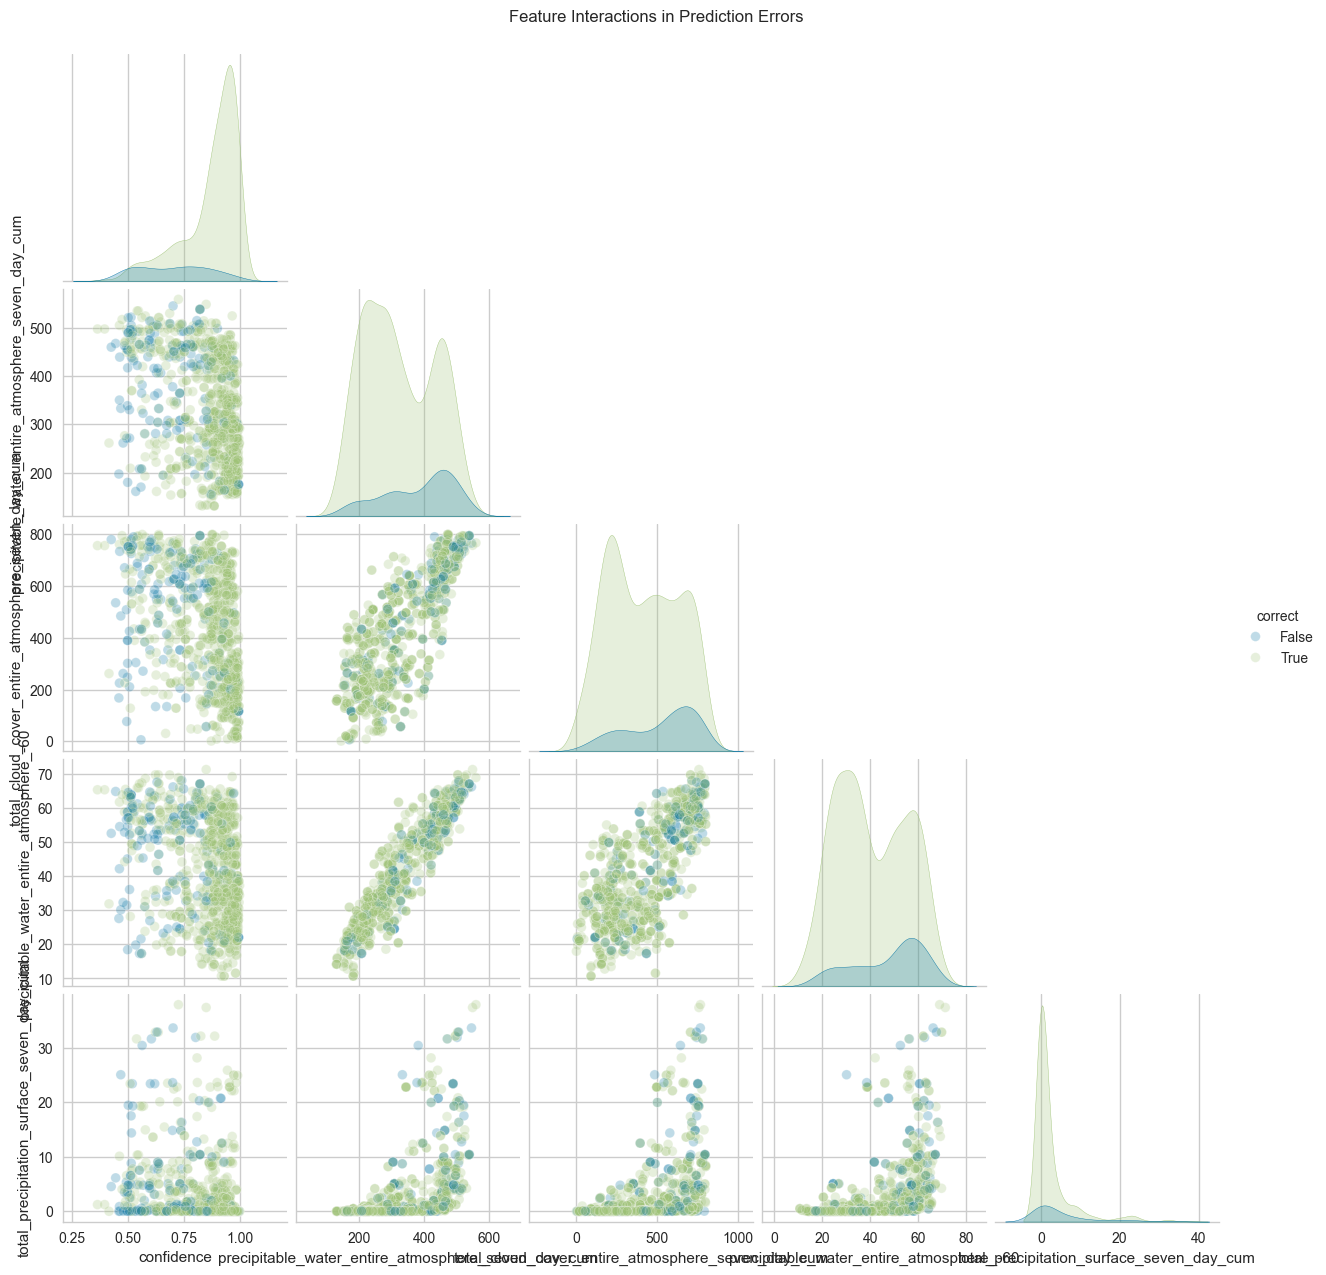

In [81]:
# Analyze errors by feature ranges
# feature_error_rates = analyze_errors_by_feature_ranges(error_df)

# Analyze feature interactions
analyze_feature_interactions_in_errors(error_df)

### Train Autogluon model

In [ ]:
# Import AutoGluon
from autogluon.tabular import TabularPredictor

# Prepare training data
train_data = pd.DataFrame({
    'features': X_train,
    'target': y_train
})

# Initialize and train AutoGluon model
predictor = TabularPredictor(label='target', problem_type='multiclass')
predictor.fit(train_data)

# Make predictions on test set
y_pred_ag = predictor.predict(X_test)

# Create error analysis dataframe similar to before
error_df_ag = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_ag,
    'correct': y_test == y_pred_ag
})

# Add feature columns for analysis
for col in X_test.columns:
    error_df_ag[col] = X_test[col]

# Analyze prediction errors by feature ranges
feature_error_rates_ag = analyze_errors_by_feature_ranges(error_df_ag)

# Analyze feature interactions
analyze_feature_interactions_in_errors(error_df_ag)

# Print model performance metrics
print("\nAutoGluon Model Performance:")
print(classification_report(y_test, y_pred_ag))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_ag)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - AutoGluon Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Scrap work

Dropping ['downward_shortwave_radiation_flux_3'] as they contain all zeros.
Dropping ['downward_shortwave_radiation_flux_3'] as they contain all zeros.


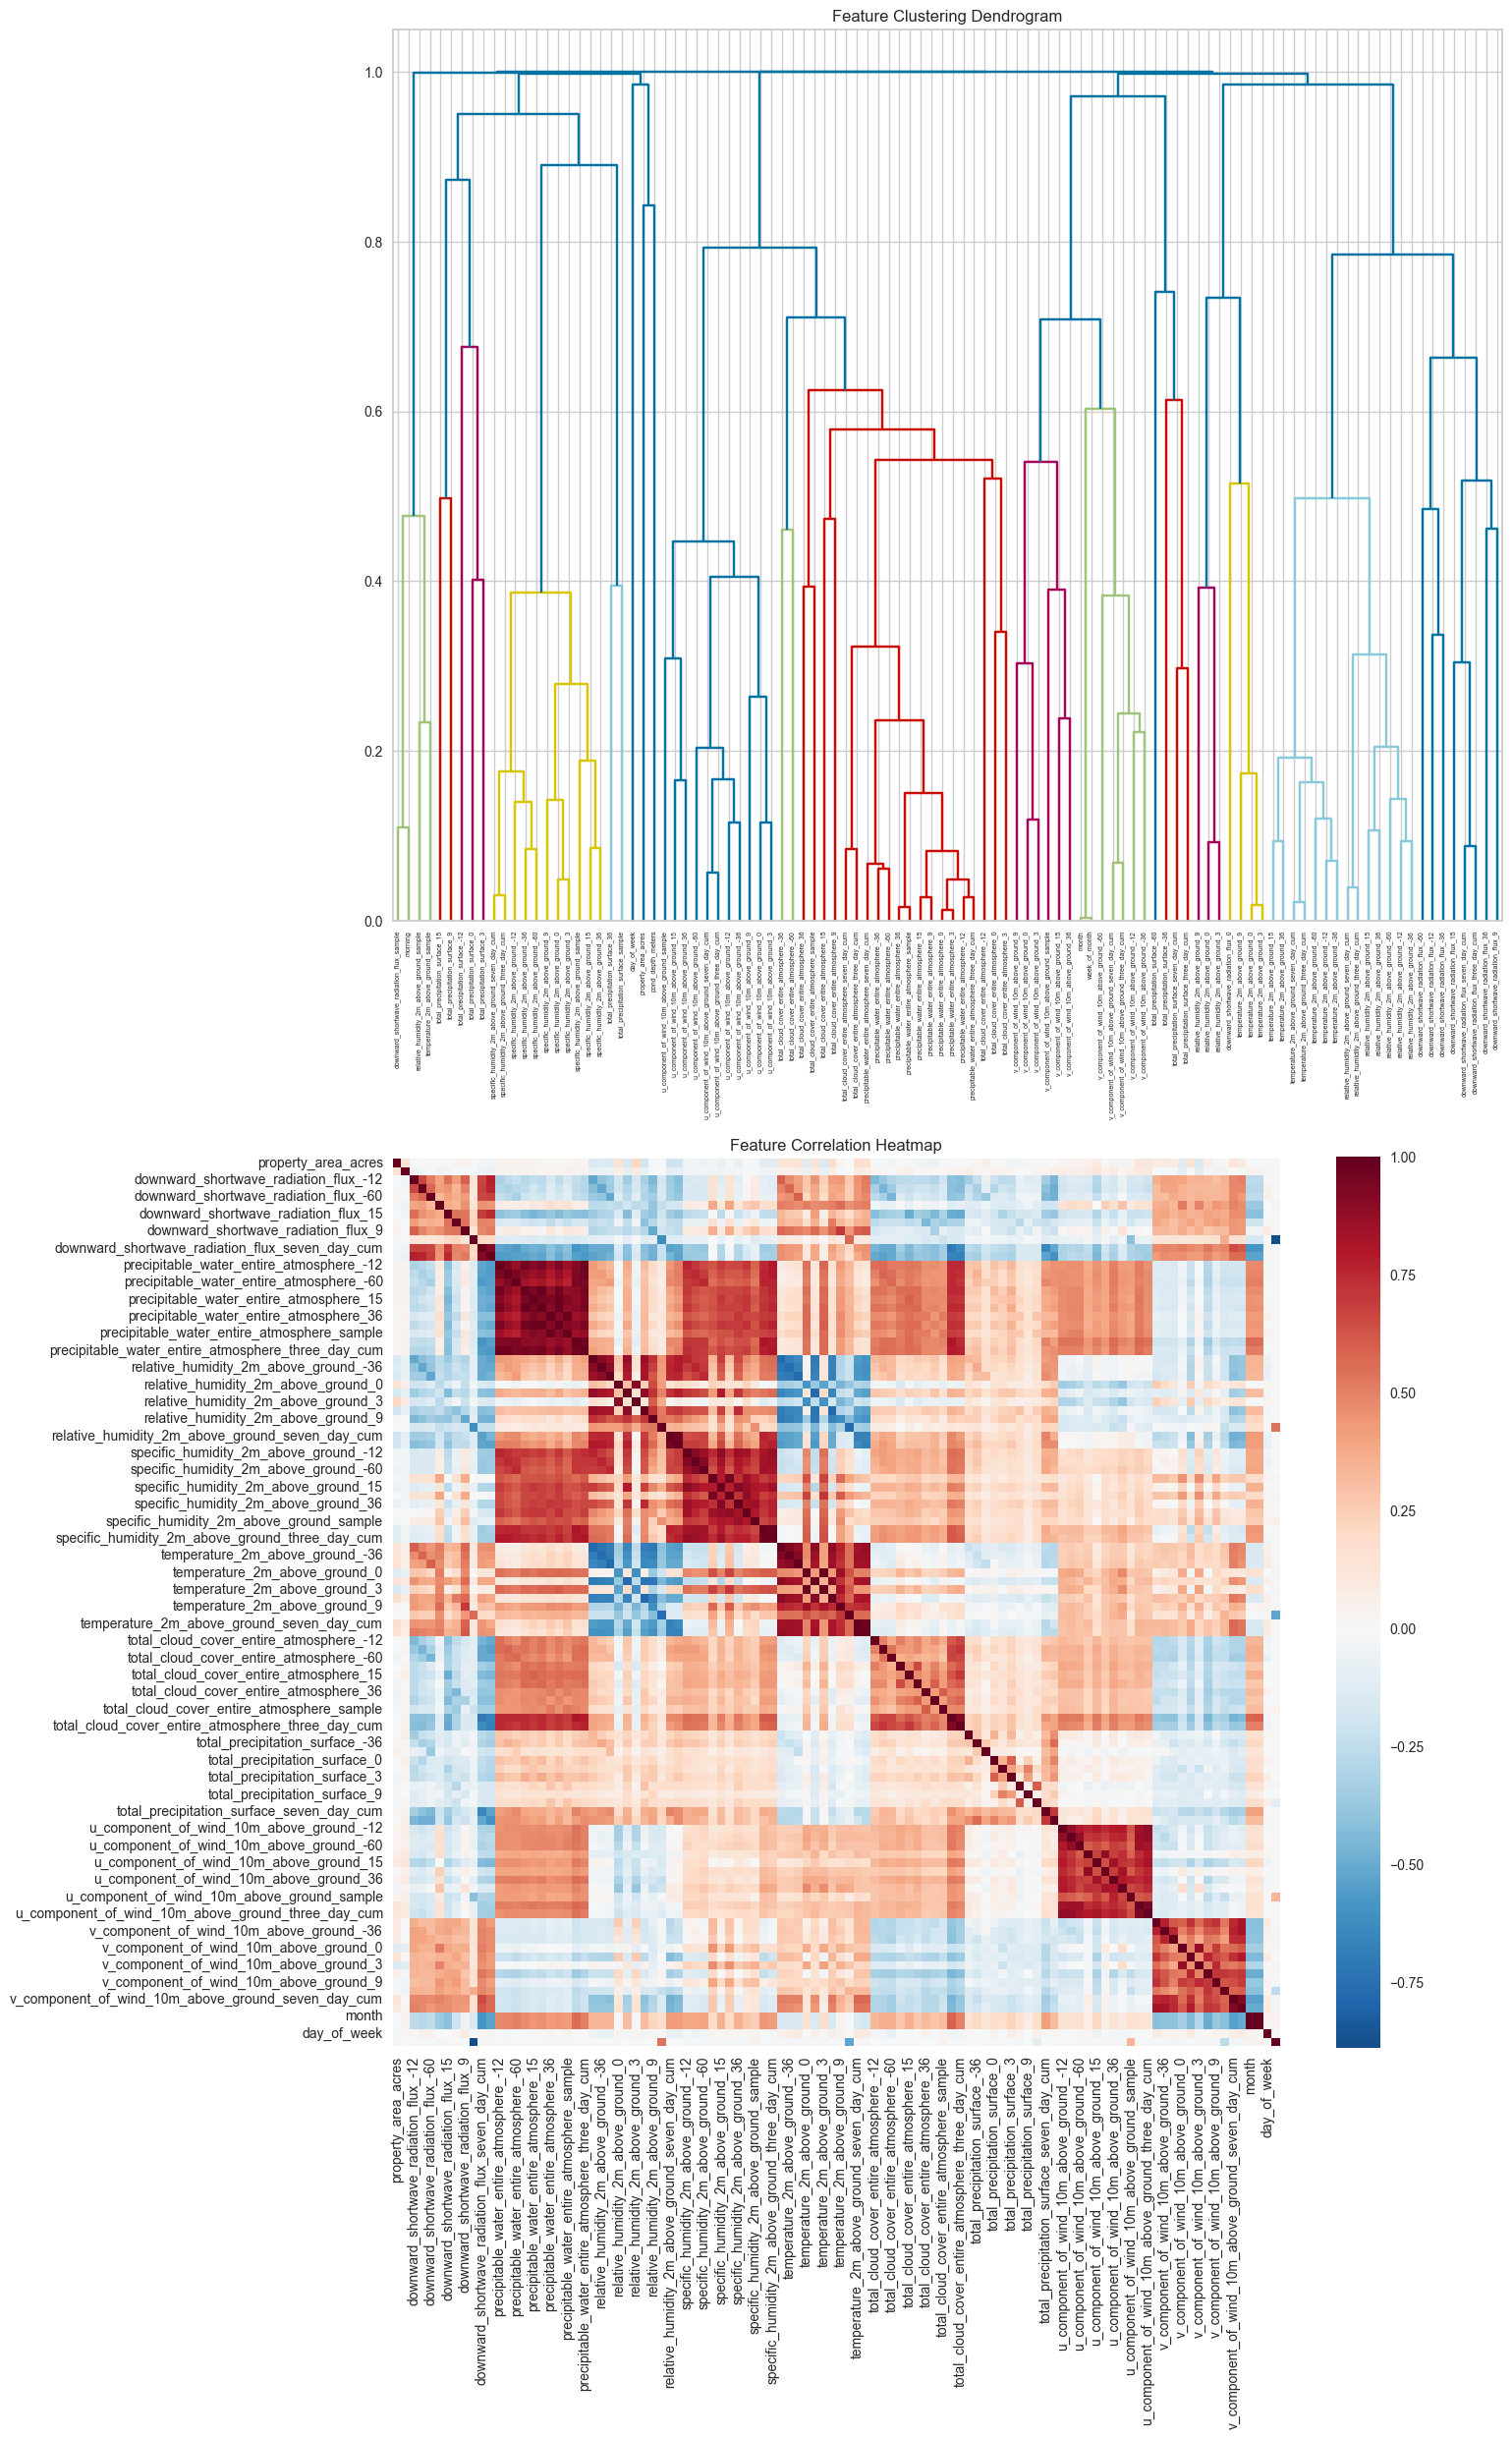


Feature Clusters (sorted by size):

Cluster 1 (6 features):
precipitable_water_entire_atmosphere_-12, precipitable_water_entire_atmosphere_0, precipitable_water_entire_atmosphere_15, precipitable_water_entire_atmosphere_3, precipitable_water_entire_atmosphere_9, precipitable_water_entire_atmosphere_three_day_cum

Cluster 2 (3 features):
precipitable_water_entire_atmosphere_-36, precipitable_water_entire_atmosphere_-60, precipitable_water_entire_atmosphere_seven_day_cum

Cluster 3 (2 features):
downward_shortwave_radiation_flux_seven_day_cum, downward_shortwave_radiation_flux_three_day_cum

Cluster 4 (2 features):
precipitable_water_entire_atmosphere_36, precipitable_water_entire_atmosphere_sample

Cluster 5 (2 features):
relative_humidity_2m_above_ground_-12, relative_humidity_2m_above_ground_-36

Cluster 6 (2 features):
relative_humidity_2m_above_ground_0, relative_humidity_2m_above_ground_3

Cluster 7 (2 features):
relative_humidity_2m_above_ground_seven_day_cum, relative_humidity_2

In [80]:
X = classify_df.drop(columns=target_columns).drop(columns='pond_area_acres')

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

def plot_correlation_heatmap(corr_matrix, figsize=(12, 10)):
    """Plot correlation heatmap with customized styling."""
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                cmap='RdBu_r',
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True,
                annot=False,
                fmt='.2f',
                cbar_kws={"shrink": .5})
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def cluster_correlated_features(X, correlation_threshold=0.9):
    """
    Cluster features based on correlation.
    
    Args:
        X (pd.DataFrame): Input features
        correlation_threshold (float): Threshold for considering features correlated
        
    Returns:
        list: List of feature clusters
    """
    # Drop columns only with zeros
    zero_cols = X.columns[X.apply(lambda col: col.eq(0).all(), axis=0)].tolist()

    if zero_cols:
      print(f"Dropping {zero_cols} as they contain all zeros.")

    keep_cols = X.columns[~X.columns.isin(zero_cols)].tolist()
    X_valid = X[keep_cols]

    # Calculate correlation matrix
    corr_matrix = X_valid.corr().abs()
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - corr_matrix
    
    # Perform hierarchical clustering
    linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='complete')
    
    # Cut the dendrogram to get clusters
    clusters = hierarchy.fcluster(linkage_matrix, 
                                  t=1-correlation_threshold, 
                                  criterion='distance')
    
    # Group features into clusters
    feature_clusters = {}
    for feature_idx, cluster_id in enumerate(clusters):
        if cluster_id not in feature_clusters:
            feature_clusters[cluster_id] = []
        feature_clusters[cluster_id].append(X_valid.columns[feature_idx])
    
    # Sort clusters by size in descending order
    sorted_clusters = sorted(feature_clusters.values(), key=len, reverse=True)
    
    return sorted_clusters

def plot_feature_clusters(X, clusters, figsize=(15, 25)):
    """
    Plot dendrogram of feature clusters with correlation heatmap.
    
    Args:
        X (pd.DataFrame): Input features
        clusters (list): List of feature clusters
        figsize (tuple): Figure size
    """
    # Drop columns only with zeros
    zero_cols = X.columns[X.apply(lambda col: col.eq(0).all(), axis=0)].tolist()

    if zero_cols:
      print(f"Dropping {zero_cols} as they contain all zeros.")

    keep_cols = X.columns[~X.columns.isin(zero_cols)].tolist()
    X_valid = X[keep_cols]

    # Calculate correlation matrix
    corr_matrix = X_valid.corr()
    distance_matrix = 1 - np.abs(corr_matrix)
    
    # Create linkage matrix
    linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='complete')
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot dendrogram
    hierarchy.dendrogram(linkage_matrix,
                         labels=X_valid.columns.tolist(),
                         leaf_rotation=90,
                         ax=ax1)
    ax1.set_title('Feature Clustering Dendrogram')
    
    # Plot correlation heatmap
    sns.heatmap(corr_matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    ax2.set_title('Feature Correlation Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Print clusters sorted by size
    print("\nFeature Clusters (sorted by size):")
    for i, cluster in enumerate(clusters, 1):
        print(f"\nCluster {i} ({len(cluster)} features):")
        print(", ".join(cluster))

# Get clusters and visualize
clusters = cluster_correlated_features(X)
plot_feature_clusters(X, clusters)

In [ ]:
# For each cluster, keep only the feature with highest correlation with target
def select_best_features_from_clusters(X, y, clusters):
    # Calculate correlation with target for all features
    target_correlations = X.corrwith(y).abs()
    
    # For each cluster, find feature with highest correlation
    selected_features = []
    for cluster in clusters:
        # Get correlations for features in this cluster
        cluster_correlations = target_correlations[cluster]
        # Select feature with highest correlation
        best_feature = cluster_correlations.idxmax()
        selected_features.append(best_feature)
        
    print(f"\nSelected {len(selected_features)} features (one from each cluster):")
    print("\n".join(selected_features))
    
    return selected_features

# Select best features
selected_features = select_best_features_from_clusters(X, y, clusters)

# Create reduced dataset with only selected features
X_reduced = X[selected_features]

print(f"\nReduced X shape: {X_reduced.shape}")


In [ ]:
# Create a custom transformer for cluster-based feature selection
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_features_ = None
        
    def fit(self, X, y):
        # Calculate correlation matrix and cluster features
        def cluster_correlated_features(X, threshold=0.8):
            # Calculate correlation matrix
            corr_matrix = X.corr().abs()
            
            # Convert correlation matrix to distance matrix
            dist_matrix = 1 - corr_matrix
            
            # Create linkage matrix for hierarchical clustering
            linkage_matrix = linkage(squareform(dist_matrix), method='complete')
            
            # Get clusters using distance threshold
            clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
            
            # Group features into clusters
            feature_clusters = {}
            for feature_idx, cluster_id in enumerate(clusters):
                if cluster_id not in feature_clusters:
                    feature_clusters[cluster_id] = []
                feature_clusters[cluster_id].append(X.columns[feature_idx])
            
            # Convert to list of clusters
            return [cluster for cluster in feature_clusters.values()]
        
        # Get clusters
        clusters = cluster_correlated_features(X)
        
        # Calculate correlation with target for all features
        target_correlations = X.corrwith(y).abs()
        
        # For each cluster, find feature with highest correlation
        selected_features = []
        for cluster in clusters:
            # Get correlations for features in this cluster
            cluster_correlations = target_correlations[cluster]
            # Select feature with highest correlation
            best_feature = cluster_correlations.idxmax()
            selected_features.append(best_feature)
            
        self.selected_features_ = selected_features
        return self
        
    def transform(self, X):
        # Validate that fit has been called
        if self.selected_features_ is None:
            raise ValueError("ClusterFeatureSelector has not been fitted yet.")
        
        # Return dataset with only selected features
        return X[self.selected_features_]

# Example usage in a pipeline:
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('feature_selector', ClusterFeatureSelector()),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Fit and predict
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
"""


In [48]:
# Check where correlation matrix is not symmetric
corr_matrix = X.corr()
distance_matrix = 1 - corr_matrix.abs()
diff = distance_matrix - distance_matrix.T
asymmetric_mask = diff > 1e-10  # Allow for small floating point differences
if asymmetric_mask.any(axis=None):
    asymmetric_pairs = np.where(asymmetric_mask)
    print("Asymmetric correlations found between:")
    for i, j in zip(*asymmetric_pairs):
        if i < j:  # Only print each pair once
            print(f"{corr_matrix.index[i]} and {corr_matrix.columns[j]}: ")
            print(f"  ({corr_matrix.index[i]}, {corr_matrix.columns[j]}) = {corr_matrix.iloc[i,j]}")
            print(f"  ({corr_matrix.columns[j]}, {corr_matrix.index[i]}) = {corr_matrix.iloc[j,i]}")
else:
    print("Correlation matrix is symmetric")

Correlation matrix is symmetric
